24/05/15 09:05:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/15 09:05:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


(777, 18)
+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+--------------------+------------------+-----------------+--------------------+------------------+------------------+-------------------+--------------------+-----------------+-----------------+
|summary|              Row#|         clonesize|          honeybee|            bumbles|            andrena|              osmia| MaxOfUpperTRange|  MinOfUpperTRange|AverageOfUpperTRange|  MaxOfLowerTRange| MinOfLowerTRange|AverageOfLowerTRange|       RainingDays|AverageRainingDays|           fruitset|           fruitmass|            seeds|            yield|
+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+--------------------+------------------+-----------------+--------------------+------------------+-------------

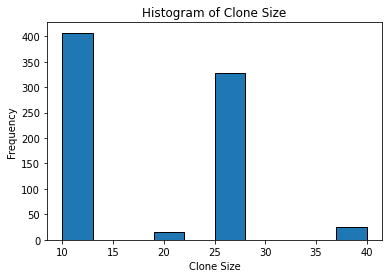

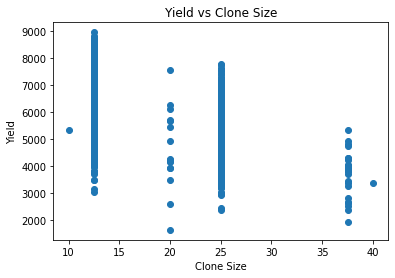

+----+---------+--------+-------+-------+-----+----------------+----------------+--------------------+----------------+----------------+--------------------+-----------+------------------+--------+---------+-----+-----+
|Row#|clonesize|honeybee|bumbles|andrena|osmia|MaxOfUpperTRange|MinOfUpperTRange|AverageOfUpperTRange|MaxOfLowerTRange|MinOfLowerTRange|AverageOfLowerTRange|RainingDays|AverageRainingDays|fruitset|fruitmass|seeds|yield|
+----+---------+--------+-------+-------+-----+----------------+----------------+--------------------+----------------+----------------+--------------------+-----------+------------------+--------+---------+-----+-----+
|   0|        0|       0|      0|      0|    0|              19|               8|                   0|               0|              17|                   8|          0|                 0|       0|        0|    0|    0|
+----+---------+--------+-------+-------+-----+----------------+----------------+--------------------+----------------+-

In [4]:
import findspark

import pyspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, mean as _mean
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()

file = "WildBlueberryPollinationSimulationData (1).csv" 
df = spark.read.csv(file, header=True, inferSchema=True)

# 打印DataFrame的形状
print((df.count(), len(df.columns)))

# The summary 
summary = df.describe()
summary.show()

# 绘制直方图和密度图需要将数据导出到pandas DataFrame中
pandas_df = df.toPandas()

import matplotlib.pyplot as plt


plt.hist(pandas_df['clonesize'], bins=10, edgecolor='black')  
plt.title('Histogram of Clone Size')
plt.xlabel('Clone Size')
plt.ylabel('Frequency')
plt.show()


clone_size_data = df.select("clonesize").rdd.flatMap(lambda x: x).collect()
yield_data = df.select("yield").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(6, 4))
plt.scatter(clone_size_data, yield_data)
plt.title('Yield vs Clone Size')
plt.xlabel('Clone Size')
plt.ylabel('Yield')
plt.show()

# Calculate the missing value
missing_values_per_column = df.select([count(F.when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values_per_column.show()

# Calculate the pre
missing_percentage = df.select([(count(F.when(col(c).isNull(), c)) / df.count() * 100).alias(c) for c in df.columns])
missing_percentage.show()

# outlier and extreme
def find_outliers(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return outliers.count()

outlier_counts = {column: find_outliers(df, column) for column in df.columns if dict(df.dtypes)[column] in ['int', 'double']}
print("Extreme counts per column:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")

def find_extremes(df, column):
    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    extremes = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return extremes.count()

extreme_counts = {column: find_extremes(df, column) for column in df.columns if dict(df.dtypes)[column] in ['int', 'double']}
print("Outlier counts per column:")
for column, count in extreme_counts.items():
    print(f"{column}: {count}")

spark.stop()
